In [10]:
import os
import numpy as np
import imageio
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from matplotlib import pyplot as plt

from utils.helpers import resize_to_256

In [9]:
crop_aug = iaa.Sometimes(
    0.9,
    iaa.Crop(
        percent=iap.Positive(iap.Normal(0, 0.1)),
        sample_independently=True,
        keep_size=False
    ),
)

# Load random bg from gi

In [8]:
path = './images'
filenames = os.listdir(path)
first_file_path = os.path.join(path, filenames[0])
sample_img = imageio.imread(first_file_path, pilmode="RGB")
sample_arr = np.array(sample_img, dtype=np.uint8)

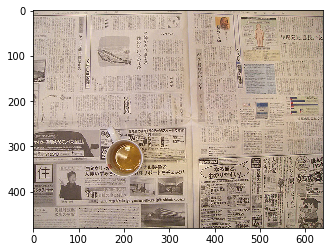

In [11]:
plt.imshow(sample_arr);

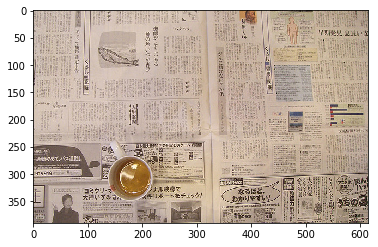

In [19]:
sample_arr_mod = crop_aug.augment_image(sample_arr)
plt.imshow(sample_arr_mod);

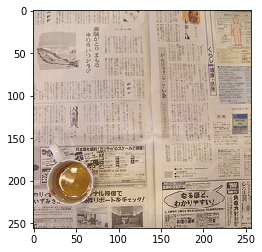

In [21]:
sample_arr_256 = resize_to_256(sample_arr_mod)
plt.imshow(sample_arr_256);

In [22]:
bg = sample_arr_256

# Load original card image

In [23]:
mask_img = imageio.imread('data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)
original_mask = np.array(mask_img, dtype=np.uint8)

card_img = imageio.imread('data/train/original_sample_1000.jpg', pilmode="RGB")
original_card = np.array(card_img, dtype=np.uint8)

In [27]:
def show_mask_and_image(mask_img, card_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_axis_off()
    axes[0].imshow(mask_img);
    axes[1].set_axis_off()
    axes[1].imshow(card_img);

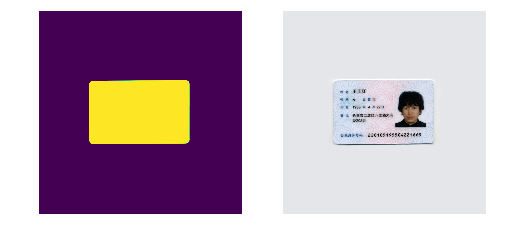

In [28]:
show_mask_and_image(mask_img, card_img)

In [25]:
affine_aug = iaa.Affine(rotate=20, mode='wrap')

rotated_mask = affine_aug.augment_image(original_mask)
rotated_card = affine_aug.augment_image(original_card)

rotated_mask_256 = resize_to_256(rotated_mask)
rotated_card_256 = resize_to_256(rotated_card)

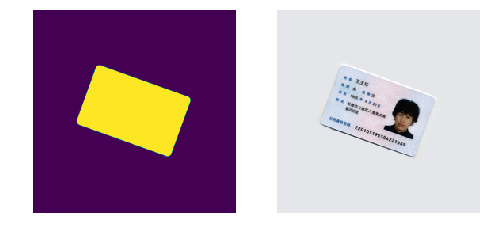

In [29]:
show_mask_and_image(rotated_mask_256, rotated_card_256)

In [30]:
def merge_by_mask(background, foreground, mask):
    w, h, chanells = background.shape
    merg_arr = np.array(background, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if mask[i][j] > 100:
                for c in range(chanells):
                    merg_arr[i][j][c] = foreground[i][j][c]
    return merg_arr

In [31]:
test_img = merge_by_mask(bg, rotated_card_256, rotated_mask_256)

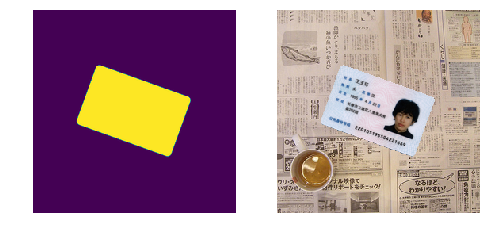

In [32]:
show_mask_and_image(rotated_mask_256, test_img)

# Predict

In [33]:
from utils.unet import get_compiled_model
from utils.helpers import show_predict_mask_above_image

Using TensorFlow backend.


In [34]:
h_size = 256
w_size = 256
start_neurons = 4

In [35]:
model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
model.load_weights('./data/weights/n4/w_n4_003.h5')

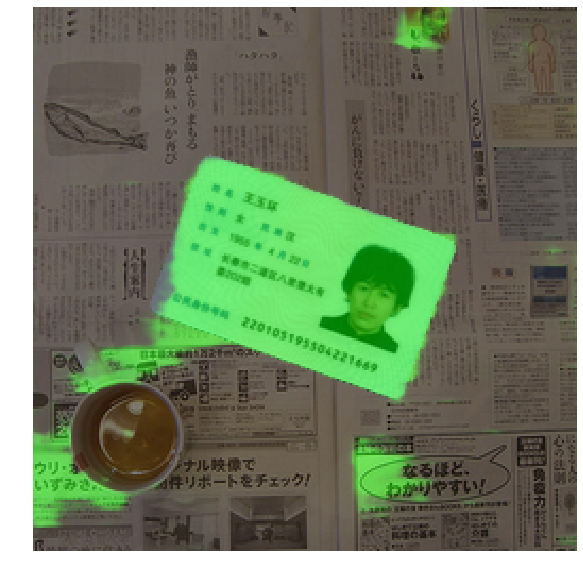

In [37]:
test_arr = np.array(test_img, dtype=np.uint8) / 255.0
show_predict_mask_above_image(test_arr, model, h_size, w_size)